I have previously appplied several regression models and analyzed their results. They were not reliable enough to be used for real-world portfolio management.

Another way to approach the main problem of stock market investing is to consider it as a classification problem: can a model predict well enough if a stock price will increase by 5% or more during the next day ?

Let's investigate by building the appropriate dataset, and train various classifiers.

In [1]:
!pip install -r requirements.txt

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, fbeta_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle
from scikitplot.metrics import plot_roc

In [49]:
X_df = utils.get_stock_feature_dataset('ALNOV.PA')

C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [4]:
X_df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-12,8.70,8.70,8.70,8.70,8.70,450.0,0.0,450.0,0.0,-24.874197,...,-2.561258,0.000000,3401.260010,3419.000000,3389.080078,3389.080078,2607.149902,2607.149902,2607.149902,2607.149902
2012-10-15,8.48,8.48,8.48,8.48,8.48,730.0,0.0,-280.0,0.0,-24.874197,...,-2.561258,-2.528736,3387.760010,3439.520020,3387.760010,3420.280029,2630.100098,2630.100098,2630.100098,2630.100098
2012-10-16,8.70,8.70,8.70,8.70,8.70,3000.0,0.0,2720.0,0.0,-24.874197,...,2.561258,0.000000,3443.600098,3500.939941,3428.969971,3500.939941,2686.030029,2686.030029,2686.030029,2686.030029
2012-10-17,8.72,8.72,8.72,8.72,8.72,800.0,0.0,3520.0,0.0,-24.874197,...,0.229621,0.229885,3503.820068,3530.790039,3494.350098,3527.500000,2704.060059,2704.060059,2704.060059,2704.060059
2012-10-18,8.83,8.83,8.83,8.83,8.83,138.0,0.0,3658.0,0.0,-24.874197,...,1.253578,1.494253,3527.760010,3542.580078,3508.399902,3535.179932,2709.370117,2709.370117,2709.370117,2709.370117


In [50]:
def make_labels_dataset(X_df, increase=0.05, label_name='increase_tomorrow'):
    '''
        increase: float between 0 and 1, equivalent to the desired % increase when multiplied by 100
        label_name: name for the column containing labels
    '''

    # Build the target dataset: label 1 if stock price increased by 5% or more in the following days, 0 otherwise
    y_df = pd.DataFrame(index=X_df.index, columns=[label_name])
    for i in range(len(X_df) - 1):
        increase_threshold = X_df['Adj Close'].iloc[i] + increase * X_df['Adj Close'].iloc[i]
        y_df.iloc[i] = 1 if X_df['Adj Close'].iloc[i+1] > increase_threshold else 0

    # Drop last row, for which there is no label
    X_df.drop(X_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return X_df, y_df

In [51]:
X_df, y_df = make_labels_dataset(X_df)

In [43]:
y_df.tail()

,increase_tomorrow
Date,
2020-07-07,0
2020-07-08,0
2020-07-09,0
2020-07-10,0
2020-07-13,0


In [52]:
# Check that labels are correct:

# There was an important increase of our stock price on the market day just after April 9th 2020
print("Let's check if this {:.2f}% increase is correctly labeled...".format((X_df.loc['2020-04-14']['Adj Close'] - X_df.loc['2020-04-09']['Adj Close']) / X_df.loc['2020-04-09']['Adj Close'] * 100))

# Get index of April 9th 2020, the day before increase
idx = len(X_df.loc[:'2020-04-09']) - 1
assert np.array_equal(X_df.loc['2020-04-09'].values, X_df.iloc[idx].values)

# Check that its corresponding label is 1
assert y_df.iloc[idx]['increase_tomorrow'] == 1

print('Good!')

Let's check if this 31.62% increase is correctly labeled...
Good!


Let's split dataset into testing and training datasets, and normalize them:

In [53]:
# Split dataset into 90-10% training-testing sets.
# They can be shuffled safely, since the specificities of
# time series are not relevant anymore for our classification task
train_X, test_X, train_y, test_y = train_test_split(X_df, y_df, train_size=0.9)

In [54]:
# Check if there are both labels in the training and testing sets
print('training set contains {:.2f}% records labeled as 1'.format(train_y.values.sum()/train_y.shape[0] * 100))
print('testing set contains {:.2f}% records labeled as 1'.format(test_y.values.sum()/test_y.shape[0] * 100))

training set contains 7.42% records labeled as 1
testing set contains 7.58% records labeled as 1


As expected, the dataset is skewed label-wise: class_weight='balanced' will be required to ensure that weights attributed by trained models give equal importance to both classes.

In [55]:
# Scale all values to have the same range:
X_scaler = MinMaxScaler().fit(train_X.values)

train_X_scaled = X_scaler.transform(train_X.values)
test_X_scaled = X_scaler.transform(test_X.values)

train_y = train_y.values.reshape(-1).astype(float)
test_y = test_y.values.reshape(-1).astype(float)

I will first use the benchmark algorithm 'DummyClassifier', and then apply and test LinearSVC, LogisticRegression, SVC, KNeighborsClassifier, RandomForestClassifier and AdaBoostClassifier.

The metrics I will evaluate for this classification task are accuracy, precision and Fbeta-score with beta=0.5 to penalize false positives more.

In [56]:
def print_metrics(y_true, y_pred):
    print('\taccuracy: {:.2f}%'.format(accuracy_score(y_true, y_pred) * 100))
    print('\tprecision: {:.2f}%'.format(precision_score(y_true, y_pred) * 100))
    print('\tfbeta: {:.3f}'.format(fbeta_score(y_true, y_pred, beta=0.5)))

def train_eval(model, train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    print('Results:')
    print_metrics(test_y, pred_y)

In [58]:
%%time
train_eval(DummyClassifier(), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 84.34%
	precision: 5.56%
	fbeta: 0.057
Wall time: 15.6 ms


In [14]:
%%time
train_eval(LinearSVC(class_weight='balanced', max_iter=100000), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 75.63%
	precision: 16.67%
	fbeta: 0.197
Wall time: 2.16 s


In [15]:
%%time
train_eval(SGDClassifier(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 28.43%
	precision: 6.71%
	fbeta: 0.082
Wall time: 31.2 ms


In [16]:
%%time
train_eval(LogisticRegression(class_weight='balanced', max_iter=100000), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 72.59%
	precision: 13.79%
	fbeta: 0.164
Wall time: 116 ms


In [17]:
%%time
train_eval(SVC(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 81.73%
	precision: 21.43%
	fbeta: 0.250
Wall time: 285 ms


In [18]:
%%time
train_eval(KNeighborsClassifier(), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 93.40%
	precision: 0.00%
	fbeta: 0.000
Wall time: 69 ms


In [19]:
%%time
train_eval(RandomForestClassifier(n_estimators=2000, class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 92.89%
	precision: 25.00%
	fbeta: 0.179
Wall time: 14.1 s


In [20]:
%%time
weak_learner = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
ada_model = AdaBoostClassifier(weak_learner, algorithm="SAMME", n_estimators=2000)
train_eval(ada_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 93.40%
	precision: 33.33%
	fbeta: 0.208
Wall time: 2min 56s


Precision and fbeta scores obtained by all these classifiers are not very good, the current dataset is most probably not adapted to this classification task.

Let's then try to get better precision and fbeta scores by aggregating a lot more stocks than just one in our training and testing sets, and re-train all these models on much more data points:

In [4]:
symbol_list = [
    'AI.PA', 'SAF.PA', 'GNFT.PA', 'ALNOV.PA', 'FDJ.PA', 'ETL.PA', 'DBV.PA',
    'BN.PA', 'KER.PA', 'AIR.PA', 'ENGI.PA', 'FP.PA', 'DG.PA', 'VIV.PA', 'VK.PA',
    'UG.PA', 'SU.PA', 'VIE.PA', 'ALPHA.PA', 'ALBIO.PA', 'CRI.PA', 'ALERS.PA',
    'SW.PA', 'RI.PA', 'MC.PA', 'CA.PA', 'OR.PA', 'SAN.PA', 'AC.PA', 'ACA.PA',
    'ORA.PA', 'EN.PA', 'LR.PA', 'CAP.PA', 'ML.PA', 'GLE.PA', 'WLN.PA', 'BNP.PA',
    'ATO.PA', 'SGO.PA', 'TEP.PA', 'COV.PA', 'SOI.PA', 'EDEN.PA', 'MDM.PA',
    'EUCAR.PA', 'BIM.PA', 'SCR.PA', 'COFA.PA', 'DIM.PA', 'AMUN.PA', 'IPS.PA',
    'SOLB.BR', 'UBI.PA', 'IPN.PA', 'CGG.PA', 'MF.PA', 'KN.PA', 'ELIS.PA', 'EDF.PA',
    'ALHYG.PA', 'ALVMG.PA', 'ALNEV.PA', 'FTI.PA', 'ALARF.PA', 'ALGBE.PA', 'ALINS.PA',
    'ALDBT.PA', 'ABIO.PA', 'AKA.PA', 'ADP.PA', 'AF.PA', 'ALD.PA', 'ALO.PA', 'ATE.PA',
    'AKE.PA', 'ADOC.PA', 'ALTA.PA', 'CDI.PA', 'AM.PA', 'DGM.PA', 'DBG.PA',
    'FNAC.PA', 'GLO.PA', 'GNE.PA', 'HSB.PA', 'RMS.PA', 'ILD.PA', 'RCO.PA',
    'MBWS.PA', 'NANO.PA', 'MERY.PA', 'MKEA.PA', 'MAU.PA', 'NXI.PA', 'SBT.PA'
]

# Enforce unicity of elements
assert len(set(symbol_list)) == len(symbol_list), 'some stocks appear more than once in the list!'

X_df = pd.DataFrame()
y_df = pd.DataFrame()

for count, symbol in enumerate(symbol_list):
    symbol_X_df = utils.get_stock_feature_dataset(symbol)
    symbol_X_df, symbol_y_df = utils.make_labels_dataset(symbol_X_df)

    # reset index since dates are not required for classification
    X_df = X_df.append(symbol_X_df.reset_index(drop=True), ignore_index=True)
    y_df = y_df.append(symbol_y_df.reset_index(drop=True), ignore_index=True)

    # print progress
    if not count % 5:
        print('Done processing {}! new X_df shape: {}, new y_df shape: {}'.format(symbol, X_df.shape, y_df.shape))

C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


Done processing AI.PA! new X_df shape: (5278, 86), new y_df shape: (5278, 1)
Done processing ETL.PA! new X_df shape: (19895, 86), new y_df shape: (19895, 1)
Done processing ENGI.PA! new X_df shape: (45186, 86), new y_df shape: (45186, 1)
Done processing UG.PA! new X_df shape: (71576, 86), new y_df shape: (71576, 1)
Done processing CRI.PA! new X_df shape: (91582, 86), new y_df shape: (91582, 1)
Done processing CA.PA! new X_df shape: (114755, 86), new y_df shape: (114755, 1)
Done processing ORA.PA! new X_df shape: (140636, 86), new y_df shape: (140636, 1)
Done processing GLE.PA! new X_df shape: (164520, 86), new y_df shape: (164520, 1)
Done processing TEP.PA! new X_df shape: (190777, 86), new y_df shape: (190777, 1)
Done processing EUCAR.PA! new X_df shape: (206541, 86), new y_df shape: (206541, 1)
Done processing AMUN.PA! new X_df shape: (223935, 86), new y_df shape: (223935, 1)
Done processing CGG.PA! new X_df shape: (248133, 86), new y_df shape: (248133, 1)
Done processing ALHYG.PA! n

In [5]:
X_df = X_df.astype(float)
X_df.replace(np.inf, np.nan, inplace=True)
X_df.replace(-np.inf, np.nan, inplace=True)
X_df.interpolate(axis=0, limit_direction='both', inplace=True)

In [6]:
X_df.isna().sum().sum()

0

In [7]:
X_df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
0,34.854301,36.306599,34.771301,35.061798,10.226519,904282.0,-5.620798e+05,904282.0,-0.402545,-833509.084988,...,-4.539366,0.000000,6024.379883,6102.120117,5901.770020,5917.370117,4035.110107,4035.110107,4035.110107,4035.110107
1,35.061798,34.999500,32.613701,33.505798,9.772677,1381445.0,-9.104260e+05,-477163.0,-0.402545,-833509.084988,...,-4.539366,-4.437879,5922.229980,5925.069824,5657.200195,5672.020020,3873.149902,3873.149902,3873.149902,3873.149902
2,32.779701,33.402100,32.281700,33.194599,9.681908,853763.0,-3.729013e+05,-1330926.0,-0.402545,-833509.084988,...,-0.933132,-5.325451,5521.830078,5589.500000,5461.589844,5479.700195,3743.870117,3743.870117,3743.870117,3743.870117
3,32.758900,36.223598,32.696701,35.580399,10.377778,1387137.0,5.082923e+05,56211.0,-0.402545,-833509.084988,...,6.940771,1.479106,5485.930176,5530.259766,5388.850098,5450.109863,3728.080078,3728.080078,3728.080078,3728.080078
4,35.580399,37.136398,34.958000,35.144798,10.250728,2198233.0,-1.312943e+06,-2142022.0,-0.402545,-833509.084988,...,-1.231828,0.236725,5423.879883,5561.689941,5423.879883,5539.609863,3794.070068,3794.070068,3794.070068,3794.070068


In [134]:
X_df.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
399488,11.10,11.10,10.92,11.10,11.10,5383.0,2.640831e+07,71270047.0,-0.095812,-320.408883,...,0.904984,-63.873068,5054.040039,5056.520020,5009.029785,5043.729980,3648.330078,3648.330078,3648.330078,3648.330078
399489,11.04,11.12,11.04,11.12,11.12,7088.0,2.641540e+07,71277135.0,-0.099468,-254.384757,...,0.180018,-63.807974,5004.819824,5040.520020,4969.830078,4981.129883,3648.330078,3648.330078,3648.330078,3648.330078
399490,10.94,11.04,10.90,11.04,11.04,2173.0,2.641757e+07,71274962.0,-0.044948,-242.878363,...,-0.722025,-64.068348,5006.520020,5014.850098,4911.560059,4921.009766,3648.330078,3648.330078,3648.330078,3648.330078
399491,10.98,11.10,10.94,11.10,11.10,1155.0,2.641873e+07,71276117.0,-0.097730,-198.281454,...,0.542007,-63.873068,4891.609863,4974.370117,4882.500000,4970.479980,3648.330078,3648.330078,3648.330078,3648.330078
399492,11.00,11.00,10.96,11.00,11.00,5869.0,2.642460e+07,71270248.0,-0.144931,-253.798389,...,-0.904984,-64.198535,5026.200195,5060.430176,4980.120117,5056.229980,3648.330078,3648.330078,3648.330078,3648.330078


In [8]:
y_df.head()

,increase_tomorrow
0,0
1,0
2,1
3,0
4,0


In [9]:
train_X, test_X, train_y, test_y = train_test_split(X_df, y_df, train_size=0.9)

In [10]:
# Check if there are both labels in the training and testing sets
print('training set contains {:.2f}% records labeled as 1'.format(train_y.values.sum()/train_y.shape[0] * 100))
print('testing set contains {:.2f}% records labeled as 1'.format(test_y.values.sum()/test_y.shape[0] * 100))

training set contains 3.56% records labeled as 1
testing set contains 3.58% records labeled as 1


In [11]:
# Scale all values to have the same range:
X_scaler = MinMaxScaler().fit(train_X.values)

train_X_scaled = X_scaler.transform(train_X.values)
test_X_scaled = X_scaler.transform(test_X.values)

train_y = train_y.values.reshape(-1).astype(float)
test_y = test_y.values.reshape(-1).astype(float)

In [28]:
%%time
train_eval(DummyClassifier(), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 93.46%
	precision: 3.73%
	fbeta: 0.037
Wall time: 69 ms


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [29]:
%%time
train_eval(LinearSVC(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 78.88%
	precision: 10.26%
	fbeta: 0.124
Wall time: 3min 21s


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [30]:
%%time
train_eval(LogisticRegression(class_weight='balanced', n_jobs=-2), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 77.12%
	precision: 9.68%
	fbeta: 0.117
Wall time: 1min 21s


In [31]:
%%time
train_eval(SVC(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 82.99%
	precision: 12.66%
	fbeta: 0.151
Wall time: 5h 34s


In [32]:
%%time
train_eval(SGDClassifier(class_weight='balanced', n_jobs=-2), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 73.88%
	precision: 8.53%
	fbeta: 0.103
Wall time: 5.57 s


In [33]:
%%time
kn_model = KNeighborsClassifier(n_jobs=-2)
train_eval(kn_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 97.24%
	precision: 81.27%
	fbeta: 0.540
Wall time: 7min 12s


In [125]:
%%time
rf_model = RandomForestClassifier(class_weight='balanced')
train_eval(rf_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 97.42%
	precision: 97.37%
	fbeta: 0.657
Wall time: 7min 2s


In [72]:
%%time
ada_model = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'))
train_eval(ada_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 95.43%
	precision: 36.18%
	fbeta: 0.362
Wall time: 1min 11s


### KNeighborsClassifier and RandomForestClassifier got promising results, let's plot their ROC curve to evaluate their classification quality in terms of false and true positive rates:

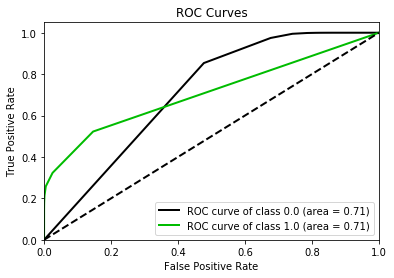

In [127]:
# ROC and AUC curve for KNN
probs = kn_model.predict_proba(test_X_scaled)
plot_roc(test_y, probs, plot_micro=False, plot_macro=False)
plt.show()

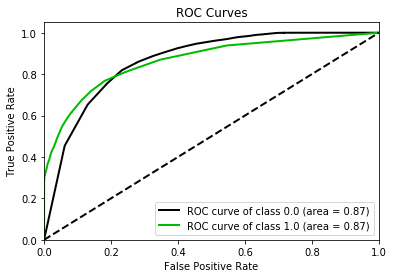

In [128]:
# ROC and AUC curve for RF
probs = rf_model.predict_proba(test_X_scaled)
plot_roc(test_y, probs, plot_micro=False, plot_macro=False)
plt.show()

KNN and RF have good AUC measures of 0.71 and 0.87 respectively, which means that both models are able to differentiate the two target classes quite well, and that RF performs a bit better than KNN.

This is confirmed by looking at the good precision and fbeta scores obtained by these two models on the testing set.

## Let's try to improve KNN:

In [126]:
%%time
kn_model = KNeighborsClassifier(n_neighbors=8, n_jobs=-2)
train_eval(kn_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 97.05%
	precision: 93.10%
	fbeta: 0.521
Wall time: 8min 50s


Changing K, the numbers of nearest neighbors, from the default value of 5 to 8 increased precision by more than 10% on the testing set.

## I will now save both models to disk so that they can be used for predictions later:

In [129]:
outfile = open('RF-clf.pickle', 'wb')
pickle.dump(rf_model, outfile)
outfile.close()

In [130]:
outfile = open('KNN-clf.pickle', 'wb')
pickle.dump(kn_model, outfile)
outfile.close()

In [131]:
# Also save the scaler used to normalize our input dataset
outfile = open('x-scaler.pickle', 'wb')
pickle.dump(X_scaler, outfile)
outfile.close()

Regarding RandomForestClassifier, the importance of features used for classification can also be analyzed:

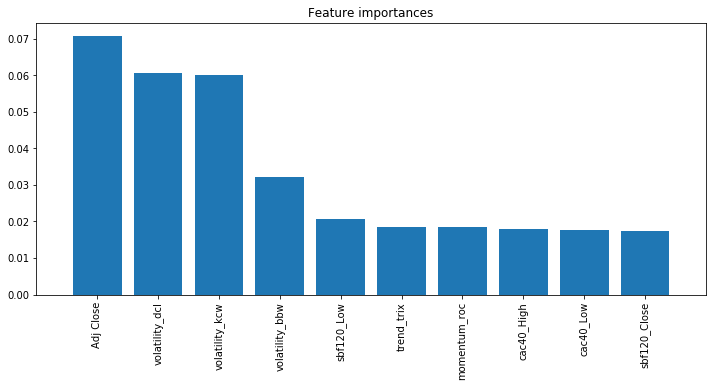

In [133]:
# Plot the top N most important features used by RandomForestClassifier
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

top_n = 10

plt.figure(figsize=(12, 5))

plt.title("Feature importances")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X_df.columns[indices[:top_n]], rotation=90)
plt.xlim([-1, top_n])
plt.show()

Like the PCA study performed earlier, the feature importance plot shows that the RF model works by using a top-10-feature mix of both traditional technical analysis indicators and features related to the main market indices of the stocks analyzed.